## CVPR2022 NAS竞赛Track 2第18名方案

方案说明：
1. 本方案基于官方的[baseline](https://aistudio.baidu.com/aistudio/projectdetail/3720834)修改而来。
2. 基于上述方案主要有两个方面的修改：
    * 修改了模型的表达方式
    * 修改了源GPNAS中的kernel function


**模型表达方式**

原始的模型表达方式（编码）太"直观"了，比如"j111231321311311221231121111231000000"这样的一串字符串，而模型的表达远比这来的要复杂，所以我的第一个想法就是如何表达模型。曾经尝试过用embdding的方式(可以参考NLP)，确实能够看到不同的embedding对模型的表示结果不同，但是反映到赛题上结果都很差。

而我这里尝试直接修改原编码字符串，参考代码中的convert_X函数，分数直接由baseline的**0.66提升到0.76**。再简单微调一下就到了**0.78**，ab榜都在18名，而与第一名也就相差1个百分点。

实话讲，不清楚为什么这样做会有这么大的提升，这样刷榜也实在不妥，所以比赛后半端就不再提交了...

这里只能分享一下我修改编码字符串的一些经验：
1. 编码字符串的长短与结果没有必然联系
2. 原始字符串与拓展字符串拼接结果最好
3. 拓展字符串需要能够最大程度区分原始串中"1,2,3"等表示方式，比如用5次方

**GPNAS中的kernel function**

GPNAS源代码中_get_corelation中提供了两个kernel function，而我这里直接使用np.abs，提升在1-2个百分点。
```python
    def _get_corelation(self, mat1, mat2):
        """
        give two typical kernel function
        
        Auto kernel hyperparameters estimation to be updated
        """

        mat_diff = abs(mat1 - mat2)

        if self.c_flag == 1:

            return 0.5 * np.exp(-np.dot(mat_diff, mat_diff) / 16)

        elif self.c_flag == 2:

            # return 1 * np.exp(-np.sqrt(np.dot(mat_diff, mat_diff)) / 12)
            _data = np.dot(mat1, mat2)
            return np.abs(_data)
```

**最后**

这次成绩偶然成分较大，欢迎大家多多交流 ：）

In [1]:
!ls /home/aistudio/data
!ls /home/aistudio/data/data134077

data134077
CVPR_2022_NAS_Track1_test.json	CVPR_2022_NAS_Track2_train.json
CVPR_2022_NAS_Track2_test.json	resnet48.pdparams


In [2]:
import os
import itertools
import sklearn
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

In [3]:
# 读取训练数据, 训练集包含500个模型结构，以及这些结构在cplfw，market1501，dukemtmc等8个任务上的性能排序
import json
with open('/home/aistudio/data/data134077/CVPR_2022_NAS_Track2_train.json', 'r') as f:
    train_data = json.load(f)
print(train_data['arch1'])
print('train_num:',len(train_data.keys()))

{'cplfw_rank': 9, 'market1501_rank': 361, 'dukemtmc_rank': 426, 'msmt17_rank': 433, 'veri_rank': 327, 'vehicleid_rank': 480, 'veriwild_rank': 425, 'sop_rank': 367, 'arch': 'l231131331121121331111211121331321321'}
train_num: 500


In [4]:
def convert_X_raw(arch_str):
    temp_arch = []
    for elm in arch_str:
        if elm == 'l':
            temp_arch.append(1)
        elif elm == 'j':
            temp_arch.append(2)
        elif elm == 'k':
            temp_arch.append(3)
        else: 
            temp_arch.append(int(elm))
    return(temp_arch)

def convert_X(arch_str):
    temp_arch = []
    # ‘j’，'k’和’l’分别表示10，11和12
    _length = 0
    _head = 0
    if arch_str[0] == 'j':
        _length = 10
        _head = 1
    elif arch_str[0] == 'k':
        _length = 11
        _head = 2
    elif arch_str[0] == 'l':
        _length = 12
        _head = 3

    temp_arch = temp_arch + [_head] + [int(s) for s in arch_str[1:]]
    temp_arch = temp_arch + [np.sin(_head)] + [np.sin(int(s)) for s in arch_str[1:]]
    temp_arch = temp_arch + [np.exp(_head)] + [np.exp(int(s)) for i in range(3)
    for s in (arch_str[1+i*_length:1+(i+1)*_length])] + [0]*(12-_length)*3
    temp_arch = temp_arch + [_head**5] + [int(s)**5 for i in range(3)
    for s in (arch_str[1+i*_length:1+(i+1)*_length])] + [0]*(12-_length)*3

    return temp_arch

train_list = [[],[],[],[],[],[],[],[]]
arch_list_train = []
name_list = ['cplfw_rank', 'market1501_rank', 'dukemtmc_rank', 'msmt17_rank', 'veri_rank', 'vehicleid_rank', 'veriwild_rank', 'sop_rank']
for key in train_data.keys():
    for idx, name in enumerate(name_list):
        train_list[idx].append(train_data[key][name])
    arch_list_train.append(convert_X(train_data[key]['arch']))
print(arch_list_train[0], arch_list_train[1])


[3, 2, 3, 1, 1, 3, 1, 3, 3, 1, 1, 2, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 1, 3, 2, 1, 3, 2, 1, 0.1411200080598672, 0.9092974268256817, 0.1411200080598672, 0.8414709848078965, 0.8414709848078965, 0.1411200080598672, 0.8414709848078965, 0.1411200080598672, 0.1411200080598672, 0.8414709848078965, 0.8414709848078965, 0.9092974268256817, 0.8414709848078965, 0.8414709848078965, 0.9092974268256817, 0.8414709848078965, 0.1411200080598672, 0.1411200080598672, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.9092974268256817, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.9092974268256817, 0.8414709848078965, 0.1411200080598672, 0.1411200080598672, 0.8414709848078965, 0.1411200080598672, 0.9092974268256817, 0.8414709848078965, 0.1411200080598672, 0.9092974268256817, 0.8414709848078965, 20.085536923187668, 7.38905609893065, 20.085536923187668, 2.718281828459045, 2.718281828459045, 20.085536923187668, 2.718281828459045, 20.0855369231

In [5]:
np.shape(arch_list_train)

(500, 148)

In [6]:

#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import copy

# __all__ = ["GPNAS"]


class GPNAS(object):
    """
    GPNAS(Gaussian Process based Neural Architecture Search) is a neural architecture search algorithm. 
    We model the correlation between architectue and performance from a Bayesian perspective. Specifically, by introducing a novel Gaussian Process based
    NAS (GP-NAS) method, the correlations are modeled by the kernel function and mean function. The kernel function is also learnable to enable adaptive modeling for complex 
    correlations in different search spaces. Furthermore, by in-corporating a mutual information based sampling method, we can theoretically ensure the high-performance 
    architecture with only a small set of samples. After addressing these problems, training GP-NAS once enables direct performance prediction of any architecture in different 
    scenarios and may obtain efficient networks for different deployment platforms.
    """

    def __init__(self, c_flag=2, m_flag=2):

        self.hp_mat = 0.0000001
        self.hp_cov = 0.01
        self.cov_w = None
        self.w = None
        self.c_flag = c_flag
        self.m_flag = m_flag

    def _get_corelation(self, mat1, mat2):
        """
        give two typical kernel function
        
        Auto kernel hyperparameters estimation to be updated
        """

        mat_diff = abs(mat1 - mat2)

        if self.c_flag == 1:

            return 0.5 * np.exp(-np.dot(mat_diff, mat_diff) / 16)

        elif self.c_flag == 2:

            # return 1 * np.exp(-np.sqrt(np.dot(mat_diff, mat_diff)) / 12)
            _data = np.dot(mat1, mat2)
            return np.abs(_data)

    def _preprocess_X(self, X):
        """
        preprocess of input feature/ tokens of architecture
        more complicated preprocess can be added such as nonlineaer transformation
        """

        X = X.tolist()
        p_X = copy.deepcopy(X)

        # for feature in p_X:
        #     feature.append(1)
        
        return p_X

    def _get_cor_mat(self, X):
        """
        get kernel matrix
        """
        X = np.array(X)
        l = X.shape[0]
        cor_mat = []

        for c_idx in range(l):
            col = []
            c_mat = X[c_idx].copy()

            for r_idx in range(l):
                r_mat = X[r_idx].copy()
                temp_cor = self._get_corelation(c_mat, r_mat)
                col.append(temp_cor)
            cor_mat.append(col)

        return np.mat(cor_mat)

    def _get_cor_mat_joint(self, X, X_train):
        """
        get kernel matrix
        """
        X = np.array(X)
        X_train = np.array(X_train)
        l_c = X.shape[0]
        l_r = X_train.shape[0]
        cor_mat = []

        for c_idx in range(l_c):
            col = []
            c_mat = X[c_idx].copy()

            for r_idx in range(l_r):
                r_mat = X_train[r_idx].copy()
                temp_cor = self._get_corelation(c_mat, r_mat)
                col.append(temp_cor)
            cor_mat.append(col)

        return np.mat(cor_mat)

    def get_predict(self, X):
        """
        get the prediction of network architecture X
        """
        X = self._preprocess_X(X)
        X = np.mat(X)

        return X * self.w

    def get_predict_jiont(self, X, X_train, Y_train):
        """
        get the prediction of network architecture X based on X_train and Y_train
        """
        X = np.mat(X)
        X_train = np.mat(X_train)
        Y_train = np.mat(Y_train)
        m_X = self.get_predict(X)
        m_X_train = self.get_predict(X_train)
        mat_train = self._get_cor_mat(X_train)
        mat_joint = self._get_cor_mat_joint(X, X_train)

        return m_X + mat_joint * np.linalg.inv(mat_train + self.hp_mat * np.eye(
            X_train.shape[0])) * (Y_train.T - m_X_train)

    def get_initial_mean(self, X, Y):
        """
        get initial mean of w
        """

        X = self._preprocess_X(X)
        X = np.mat(X)
        Y = np.mat(Y)
        self.w = np.linalg.inv(X.T * X + self.hp_mat * np.eye(X.shape[
            1])) * X.T * Y.T

        return self.w

    def get_initial_cov(self, X):
        """
        get initial coviarnce matrix of w
        """

        X = self._preprocess_X(X)
        X = np.mat(X)
        self.cov_w = self.hp_cov * np.eye(X.shape[1])

        return self.cov_w

    def get_posterior_mean(self, X, Y):
        """
        get posterior mean of w
        """

        X = self._preprocess_X(X)
        X = np.mat(X)
        Y = np.mat(Y)
        cov_mat = self._get_cor_mat(X)
        if self.m_flag == 1:
            self.w = self.w + self.cov_w * X.T * np.linalg.inv(
                np.linalg.inv(cov_mat + self.hp_mat * np.eye(X.shape[0])) + X *
                self.cov_w * X.T + self.hp_mat * np.eye(X.shape[0])) * (
                    Y.T - X * self.w)
        else:
            self.w = np.linalg.inv(X.T * np.linalg.inv(
                cov_mat + self.hp_mat * np.eye(X.shape[0])) * X + np.linalg.inv(
                    self.cov_w + self.hp_mat * np.eye(X.shape[
                        1])) + self.hp_mat * np.eye(X.shape[1])) * (
                            X.T * np.linalg.inv(cov_mat + self.hp_mat * np.eye(
                                X.shape[0])) * Y.T +
                            np.linalg.inv(self.cov_w + self.hp_mat * np.eye(
                                X.shape[1])) * self.w)

        return self.w

    def get_posterior_cov(self, X, Y):
        """
        get posterior coviarnce matrix of w
        """

        X = self._preprocess_X(X)
        X = np.mat(X)
        Y = np.mat(Y)
        cov_mat = self._get_cor_mat(X)
        self.cov_mat = np.linalg.inv(
            np.linalg.inv(X.T * cov_mat * X + self.hp_mat * np.eye(X.shape[1]))
            + np.linalg.inv(self.cov_w + self.hp_mat * np.eye(X.shape[
                1])) + self.hp_mat * np.eye(X.shape[1]))

        return self.cov_mat

In [7]:
data_x = np.array(arch_list_train)
data_y = np.array(train_list)
print(data_x.shape, data_y.shape)

(500, 148) (8, 500)


In [8]:
# from paddleslim.nas import GPNAS
import numpy as np
import scipy
import scipy.stats

gp_list = []


for i in range(len(train_list[:])):
    # 每个任务有该任务专属的gpnas预测器
    gp_list.append(GPNAS(2,2)) # baseline
    # gp_list.append(GPNAS(1,2)) # v1
    # gp_list.append(GPNAS(1,1)) # v2
    # gp_list.append(GPNAS(2,1)) # v3

train_num = 480

amg_list = []
amgj_list = []
kt_list = []
ktj_list = []

for i in range(len(train_list[:])):
    # 划分训练及测试集
    X_all_k, Y_all_k  = data_x, data_y[i]
    X_train_k, Y_train_k, X_test_k, Y_test_k = X_all_k[0:train_num:1], Y_all_k[0:train_num:1], X_all_k[train_num::1], Y_all_k[train_num::1]
    # 初始该任务的gpnas预测器参数
    gp_list[i].get_initial_mean(X_train_k[0::2],Y_train_k[0::2])
    init_cov = gp_list[i].get_initial_cov(X_train_k)
    # 更新（训练）gpnas预测器超参数
    gp_list[i].get_posterior_mean(X_train_k[1::2],Y_train_k[1::2])  
   
    # 基于测试评估预测误差   
    y_pred = gp_list[i].get_predict(X_test_k)
    y_pred_joint = gp_list[i].get_predict_jiont(X_test_k, X_train_k[::1], Y_train_k[::1])

    error_list_gp = np.array(Y_test_k.reshape(len(Y_test_k),1)-y_pred)
    error_list_gp_j = np.array(Y_test_k.reshape(len(Y_test_k),1)-y_pred_joint)
    
    ave_mean_gp = np.mean(abs(np.divide(error_list_gp,Y_test_k.reshape(len(Y_test_k),1) )))
    ave_mean_gp_joint = np.mean(abs(np.divide(error_list_gp_j,Y_test_k.reshape(len(Y_test_k),1) )))
    print('AVE mean gp :', ave_mean_gp)
    print('AVE mean gp jonit :', ave_mean_gp_joint)
    # y_predict = gp_list[i].get_predict_jiont(X_test_k, X_train_k[::1], Y_train_k[::1])

    #基于测试集评估预测的Kendalltau
    kt = scipy.stats.stats.kendalltau(y_pred,Y_test_k)
    print('Kendalltau:', kt)
    ktj = scipy.stats.stats.kendalltau(y_pred_joint,Y_test_k)
    print('Kendalltau joint:', ktj)

    amg_list.append(ave_mean_gp)
    amgj_list.append(ave_mean_gp_joint)
    kt_list.append(kt)
    ktj_list.append(ktj)

import scipy.stats
print('amg', scipy.stats.describe(amg_list))
print('amgl', scipy.stats.describe(amgj_list))
print('kt', scipy.stats.describe(kt_list))
print('ktj', scipy.stats.describe(ktj_list))


AVE mean gp : 1.299788574090299
AVE mean gp jonit : 1.0723321789788158
Kendalltau: KendalltauResult(correlation=0.16842105263157894, pvalue=0.3188964804719496)
Kendalltau joint: KendalltauResult(correlation=0.23157894736842105, pvalue=0.1649764063636054)
AVE mean gp : 0.26316373137516885
AVE mean gp jonit : 0.22960139533501134
Kendalltau: KendalltauResult(correlation=0.6947368421052632, pvalue=3.318592792384182e-06)
Kendalltau joint: KendalltauResult(correlation=0.6947368421052632, pvalue=3.318592792384182e-06)
AVE mean gp : 0.2908729038847623
AVE mean gp jonit : 0.3587614045704137
Kendalltau: KendalltauResult(correlation=0.9263157894736842, pvalue=4.97267870195355e-13)
Kendalltau joint: KendalltauResult(correlation=0.9263157894736842, pvalue=4.97267870195355e-13)
AVE mean gp : 0.9686897408607986
AVE mean gp jonit : 0.8820272111648467
Kendalltau: KendalltauResult(correlation=0.9473684210526316, pvalue=3.348593561359954e-14)
Kendalltau joint: KendalltauResult(correlation=0.9157894736842

In [9]:
y_predict = y_pred

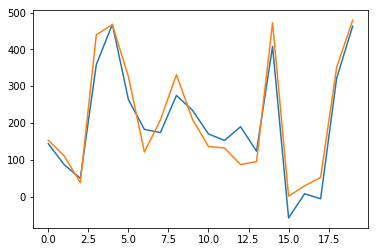

In [10]:
plt.plot(y_predict)
plt.plot(Y_test_k)

In [11]:
with open('/home/aistudio/data/data134077/CVPR_2022_NAS_Track2_test.json', 'r') as f:
    test_data = json.load(f)
test_data['arch99997']


{'cplfw_rank': 0,
 'market1501_rank': 0,
 'dukemtmc_rank': 0,
 'msmt17_rank': 0,
 'veri_rank': 0,
 'vehicleid_rank': 0,
 'veriwild_rank': 0,
 'sop_rank': 0,
 'arch': 'j121221121221221311331321121221000000'}

In [12]:
test_arch_list = []
for key in test_data.keys():
    test_arch =  convert_X(test_data[key]['arch'])
    test_arch_list.append(test_arch)
print(test_arch_list[99499])


[3, 2, 2, 1, 3, 3, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 1, 3, 1, 1, 3, 2, 1, 3, 3, 1, 0.1411200080598672, 0.9092974268256817, 0.9092974268256817, 0.8414709848078965, 0.1411200080598672, 0.1411200080598672, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.9092974268256817, 0.9092974268256817, 0.8414709848078965, 0.8414709848078965, 0.1411200080598672, 0.8414709848078965, 0.9092974268256817, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.8414709848078965, 0.9092974268256817, 0.8414709848078965, 0.9092974268256817, 0.1411200080598672, 0.8414709848078965, 0.1411200080598672, 0.8414709848078965, 0.8414709848078965, 0.1411200080598672, 0.9092974268256817, 0.8414709848078965, 0.1411200080598672, 0.1411200080598672, 0.8414709848078965, 20.085536923187668, 7.38905609893065, 7.38905609893065, 2.718281828459045, 20.085536923187668, 20.085536923187668, 2.718281828459045, 2.718281828459

In [ ]:
rank_all_slow = []
rank_all_fast = []
for task in range(len(name_list)):
    print('Predict the rank of:', name_list[task])
    # slow mode
    rank_all_slow.append(gp_list[task].get_predict_jiont(np.array(test_arch_list), np.array(arch_list_train), np.array(train_list[task])))
    # fast mode
    rank_all_fast.append(gp_list[task].get_predict(np.array(test_arch_list)))


Predict the rank of: cplfw_rank
Predict the rank of: market1501_rank
Predict the rank of: dukemtmc_rank
Predict the rank of: msmt17_rank
Predict the rank of: veri_rank
Predict the rank of: vehicleid_rank
Predict the rank of: veriwild_rank
Predict the rank of: sop_rank


In [ ]:
base_i = 1
for idx,key in enumerate(test_data.keys()):
    test_data[key]['cplfw_rank'] = int(rank_all_fast[0][idx][0]*base_i)
    test_data[key]['market1501_rank'] = int(rank_all_fast[1][idx][0]*base_i)
    test_data[key]['dukemtmc_rank'] = int(rank_all_fast[2][idx][0]*base_i)
    test_data[key]['msmt17_rank'] = int(rank_all_fast[3][idx][0]*base_i)
    test_data[key]['veri_rank'] = int(rank_all_fast[4][idx][0]*base_i)
    test_data[key]['vehicleid_rank'] = int(rank_all_fast[5][idx][0]*base_i)
    test_data[key]['veriwild_rank'] = int(rank_all_fast[6][idx][0]*base_i)
    test_data[key]['sop_rank'] = int(rank_all_fast[7][idx][0]*base_i)
print('Ready to save results!')
with open('./result/submit_gpnas_v6_6_fast.json', 'w') as f:
    json.dump(test_data, f)


In [ ]:
base_i = 1
for idx,key in enumerate(test_data.keys()):
    test_data[key]['cplfw_rank'] = int(rank_all_slow[0][idx][0]*base_i)
    test_data[key]['market1501_rank'] = int(rank_all_slow[1][idx][0]*base_i)
    test_data[key]['dukemtmc_rank'] = int(rank_all_slow[2][idx][0]*base_i)
    test_data[key]['msmt17_rank'] = int(rank_all_slow[3][idx][0]*base_i)
    test_data[key]['veri_rank'] = int(rank_all_slow[4][idx][0]*base_i)
    test_data[key]['vehicleid_rank'] = int(rank_all_slow[5][idx][0]*base_i)
    test_data[key]['veriwild_rank'] = int(rank_all_slow[6][idx][0]*base_i)
    test_data[key]['sop_rank'] = int(rank_all_slow[7][idx][0]*base_i)
print('Ready to save results!')
with open('./result/submit_gpnas_v6_6_slow.json', 'w') as f:
    json.dump(test_data, f)
